In [1]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
import os
import glob
import re

In [2]:
import numpy as np
#%EWT functions
def ewt_vineet(f,boundaries):
    # signal spectrum
    ff = np.fft.fft(f)
    ff = abs(ff[0:int(np.ceil(ff.size / 2))])  # one-sided magnitude

    #extend the signal by mirroring to deal with boundaries
    ltemp = int(np.ceil(f.size/2)) #to behave the same as matlab's round
    fMirr =  np.append(np.flip(f[0:ltemp-1],axis = 0),f)
    fMirr = np.append(fMirr,np.flip(f[-ltemp-1:-1],axis = 0))
    ffMirr = np.fft.fft(fMirr)
    # build the corresponding filter bank
    mfb = EWT_Meyer_FilterBank(boundaries, ffMirr.size)

    # filter the signal to extract each subband
    ewt = np.zeros(mfb.shape)
    for k in range(mfb.shape[1]):
        ewt[:, k] = np.real(np.fft.ifft(np.conjugate(mfb[:, k]) * ffMirr))
    ewt = ewt[ltemp - 1:-ltemp, :]

    return ewt


def EWT_Meyer_FilterBank(boundaries, Nsig):
    """
     =========================================================================
     function mfb=EWT_Meyer_FilterBank(boundaries,Nsig)

     This function generate the filter bank (scaling function + wavelets)
     corresponding to the provided set of frequency segments

     Input parameters:
       -boundaries: vector containing the boundaries of frequency segments (0
                    and pi must NOT be in this vector)
       -Nsig: signal length

     Output:
       -mfb: cell containing each filter (in the Fourier domain), the scaling
             function comes first and then the successive wavelets

     Author: Jerome Gilles
     Institution: UCLA - Department of Mathematics
     Year: 2012
     Version: 1.0

     Python Version: Vinícius Rezende Carvalho - vrcarva@ufmg.br
     Universidade Federal de Minas Gerais - Brasil
     Núcleo de Neurociências
     =========================================================================
     """
    Npic = len(boundaries)
    # compute gamma
    gamma = 1
    for k in range(Npic - 1):
        r = (boundaries[k + 1] - boundaries[k]) / (boundaries[k + 1] + boundaries[k])
        if r < gamma:
            gamma = r
    r = (np.pi - boundaries[Npic - 1]) / (np.pi + boundaries[Npic - 1])
    if r < gamma:
        gamma = r
    gamma = (1 - 1 / Nsig) * gamma  # this ensure that gamma is chosen as strictly less than the min

    mfb = np.zeros([Nsig, Npic + 1])

    # EWT_Meyer_Scaling
    Mi = int(np.floor(Nsig / 2))
    w = np.fft.fftshift(np.linspace(0, 2 * np.pi - 2 * np.pi / Nsig, num=Nsig))
    w[0:Mi] = -2 * np.pi + w[0:Mi]
    aw = abs(w)
    yms = np.zeros(Nsig)
    an = 1. / (2 * gamma * boundaries[0])
    pbn = (1. + gamma) * boundaries[0]
    mbn = (1. - gamma) * boundaries[0]
    for k in range(Nsig):
        if aw[k] <= mbn:
            yms[k] = 1
        elif ((aw[k] >= mbn) and (aw[k] <= pbn)):
            yms[k] = np.cos(np.pi * EWT_beta(an * (aw[k] - mbn)) / 2)
    yms = np.fft.ifftshift(yms)
    mfb[:, 0] = yms

    # generate rest of the wavelets
    for k in range(Npic - 1):
        mfb[:, k + 1] = EWT_Meyer_Wavelet(boundaries[k], boundaries[k + 1], gamma, Nsig)

    mfb[:, Npic] = EWT_Meyer_Wavelet(boundaries[Npic - 1], np.pi, gamma, Nsig)

    return mfb
def EWT_beta(x):
    """
    Beta = EWT_beta(x)
    function used in the construction of Meyer's wavelet
    """
    if x<0:
        bm=0
    elif x>1:
        bm=1
    else:
        bm=(x**4)*(35.-84.*x+70.*(x**2)-20.*(x**3))
    return bm
def EWT_Meyer_Wavelet(wn,wm,gamma,Nsig):
    """
    =========================================================
    ymw=EWT_Meyer_Wavelet(wn,wm,gamma,N)
    
    Generate the 1D Meyer wavelet in the Fourier
    domain associated to scale segment [wn,wm] 
    with transition ratio gamma
    
    Input parameters:
      -wn : lower boundary
      -wm : upper boundary
      -gamma : transition ratio
      -N : number of point in the vector
    
    Output:
      -ymw: Fourier transform of the wavelet on the band [wn,wm]
    Author: Jerome Gilles
    Institution: UCLA - Department of Mathematics
    Year: 2012
    Version: 1.0
    
    Python Version: Vinícius Rezende Carvalho - vrcarva@ufmg.br
    Universidade Federal de Minas Gerais - Brasil
    Núcleo de Neurociências 
    ==========================================================            
    """
    Mi=int(np.floor(Nsig/2))
    w=np.fft.fftshift(np.linspace(0,2*np.pi - 2*np.pi/Nsig,num = Nsig))
    w[0:Mi]=-2*np.pi+w[0:Mi]
    aw=abs(w)
    ymw=np.zeros(Nsig)
    an=1./(2*gamma*wn)
    am=1./(2*gamma*wm)
    pbn=(1.+gamma)*wn
    mbn=(1.-gamma)*wn
    pbm=(1.+gamma)*wm
    mbm=(1.-gamma)*wm

    for k in range(Nsig):
        if ((aw[k]>=pbn) and (aw[k]<=mbm)):
            ymw[k]=1
        elif ((aw[k]>=mbm) and (aw[k]<=pbm)):
            ymw[k]=np.cos(np.pi*EWT_beta(am*(aw[k]-mbm))/2)
        elif ((aw[k]>=mbn) and (aw[k]<=pbn)):
            ymw[k]=np.sin(np.pi*EWT_beta(an*(aw[k]-mbn))/2)
    ymw=np.fft.ifftshift(ymw)
    return ymw

In [4]:
cd Raw_files

C:\Users\vinee\Documents\BTP\Raw_files


In [5]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 62D1-0539

 Directory of C:\Users\vinee\Documents\BTP\Raw_files

23-07-2022  23:20    <DIR>          .
23-07-2022  23:20    <DIR>          ..
20-07-2022  11:49            12,710 Datasetcreation.m
16-07-2022  22:33             2,721 datasetinfo.txt
16-07-2022  10:58             2,717 DatasetInformationF1.txt
14-08-2022  11:58    <DIR>          n1f1r2
20-07-2022  11:05    <DIR>          n1f1r3
20-07-2022  11:15    <DIR>          n1f1r4
20-07-2022  11:22    <DIR>          n1f1r5
20-07-2022  11:32    <DIR>          n1f1r6
20-07-2022  11:43    <DIR>          n1f1r7
20-07-2022  11:48    <DIR>          n1f1r8
21-07-2022  15:04    <DIR>          n2f1r2
21-07-2022  15:06    <DIR>          n2f1r3
21-07-2022  15:09    <DIR>          n2f1r4
21-07-2022  15:11    <DIR>          n2f1r5
21-07-2022  15:15    <DIR>          n2f1r6
21-07-2022  15:36    <DIR>          n2f1r7
21-07-2022  15:38    <DIR>          n2f1r8
21-07-2022  14:55    <DIR>     

48khz  -- > 480 samples
<br>
3khz --> 30 samples

In [6]:
pwd

'C:\\Users\\vinee\\Documents\\BTP\\Raw_files'

In [7]:
cd ..

C:\Users\vinee\Documents\BTP


In [8]:
cd resampled_dataset_f1_n1/resampled_dataset/

C:\Users\vinee\Documents\BTP\resampled_dataset_f1_n1\resampled_dataset


In [23]:
test = np.loadtxt('F1_raw_N1_R1_cycle_1_10.txt')

In [17]:
len(test)

126

In [18]:
""" first 10 seconds ==> 30 samples
"""

' first 10 seconds ==> 30 samples\n'

In [21]:
test[2:30]

array([-15502.7321436 , -12905.83556151,  -6969.86933312,  -2335.72098765,
         3503.53850186,   8371.34343764,  10263.88655793,  13111.55460462,
        16168.73055846,  16202.29540444,  16493.08878519,  14696.4787333 ,
         8948.90811539,   6246.06708856,   1589.80333761,  -2196.57213329,
         1051.65204935,   3462.17564949,   4464.94378197,   4188.37693295,
         5253.70826739,   6918.84265784,   6241.49956202,   2357.96960762,
        -6313.55648384, -15795.81147124, -21260.84128447, -18315.88727828])

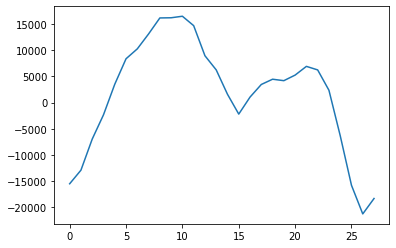

In [22]:
plt.plot(test[2:30])

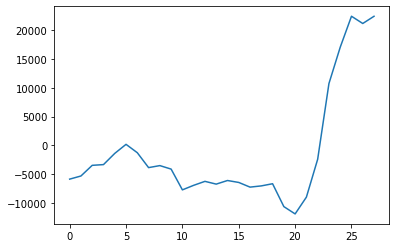

In [24]:
plt.plot(test[2:30])

In [25]:

"""
for every file
test[2:30]
np.savetxt(fname,test[2:30])

"""

'\nfor every file\ntest[2:30]\nnp.savetxt(fname,test[2:30])\n\n'

In [27]:
pwd

'C:\\Users\\vinee\\Documents\\BTP\\resampled_dataset_f1_n1\\resampled_dataset'

In [44]:
# N1 F1
my_files = glob.glob('*txt')
for i in range(len(my_files)):
    file = np.loadtxt(my_files[i])
    np.savetxt(f"C:/Users/vinee/Documents/BTP/Dataset_3KHz_10s_n1/{my_files[i]}",file[:30])

In [28]:
my_files = glob.glob('*txt')


In [42]:
print(f"C:/Users/vinee/Documents/BTP/Dataset_3KHz_10s_n1/{my_files[0][:-4]}")

C:/Users/vinee/Documents/BTP/Dataset_3KHz_10s_n1/F1_raw_N1_R1_cycle_1000_10
